In [1]:
from Utils import *

# Loading Data
mat = scipy.io.loadmat('dataExample.mat')
s1 = mat['dn']


# Setting the seed for numpy-generated random numbers
np.random.seed(37)

# Setting the seed for python random numbers
rn.seed(1254)

# Setting the graph-level random seed.
tf.set_random_seed(89)

# Setting the Parameters of the SCALOGRAM
# project
dt = 0.001
fs = 1/dt
f_min=1e-8
f_max = fs/4
fo = 5
nf = 256




Using TensorFlow backend.
C:\Users\owner\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\owner\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\owner\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\owner\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# Bulding CAE Model
temp1 = np.zeros((np.shape(s1)[1],np.shape(s1)[0],nf))
npts = s1.shape[0]
t1 = np.linspace(0, dt * npts, npts)
s2 = temp1
INPUT_SIZE1 = s2.shape[0]
INPUT_SIZE2 = s2.shape[1]
INPUT_SIZE3 = s2.shape[2]



input_img = Input(shape=(INPUT_SIZE2,INPUT_SIZE3,1))


D1 = int(nf/128)
D2 = int(D1*2)
D3 = int(D1*4)
D4 = int(D1*8)
D5 = int(D1*16)
D6 = int(D1*32)
D7 = int(D1*64)
D8 = int(D1*128)
latent_dim = D4

kernel_size = 6,6

encoded1 = Conv2D(D1, kernel_size, strides = (1,4), padding = 'same')(input_img)
encoded1 = BatchNormalization()(encoded1)
encoded1 = Activation('relu')(encoded1)
#encoded1 = Dropout(0.5)(encoded1)

encoded2 = Conv2D(D2, kernel_size, strides = (1,4), padding = 'same')(encoded1)
encoded2 = BatchNormalization()(encoded2)
encoded2 = Activation('relu')(encoded2)
#encoded2 = Dropout(0.5)(encoded2)

encoded3 = Conv2D(D3, kernel_size, strides = (1,4), padding = 'same')(encoded2)
encoded3 = BatchNormalization()(encoded3)
encoded3 = Activation('relu')(encoded3)
#encoded3 = Dropout(0.5)(encoded3)

encoded4 = Conv2D(D4, kernel_size, strides = (1,4), padding = 'same')(encoded3)
encoded4 = BatchNormalization()(encoded4)
encoded4 = Activation('relu', name = 'visualized_layer_enc')(encoded4)
#encoded4 = Dropout(0.5)(encoded4)



mu    = Conv2D(latent_dim, kernel_size, strides = (1,1), padding = 'same', activation='relu')(encoded4)
sigma = Conv2D(latent_dim, kernel_size, strides = (1,1), padding = 'same', activation='relu')(encoded4)


# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch     = K.shape(mu)[2]
    dim       = K.int_shape(mu)[3]
    eps       = K.random_normal(shape=(batch, dim),mean=0., stddev=1.0)
    return mu + K.exp(sigma/2) * eps
    #return mu + K.exp(sigma / 2) * eps


# Use reparameterization trick to ensure correct gradient
z       = Lambda(sample_z, output_shape=(INPUT_SIZE2,1,latent_dim), name='z')([mu, sigma])
z = Conv2D(latent_dim, kernel_size, strides = (1,1), padding = 'same', activation='relu')(z)

# Decoder
decoded1 = Conv2DTranspose(D4, kernel_size, strides = (1,4), padding = 'same')(encoded4)
decoded1 = BatchNormalization()(decoded1)
decoded1 = Activation('relu')(decoded1)

decoded2 = Conv2DTranspose(D3, kernel_size, strides = (1,4), padding = 'same')(decoded1)
decoded2 = BatchNormalization()(decoded2)
decoded2 = Activation('relu')(decoded2)

decoded3 = Conv2DTranspose(D2, kernel_size, strides = (1,4), padding = 'same')(decoded2)
decoded3 = BatchNormalization()(decoded3)
decoded3 = Activation('relu')(decoded3)

decoded4 = Conv2DTranspose(D1, kernel_size, strides = (1,4), padding = 'same')(decoded3)
decoded4 = BatchNormalization()(decoded4)
decoded4 = Activation('relu')(decoded4)

decoded = Conv2D(1, kernel_size, strides = (1,1), padding = 'same', activation='linear', name = 'visualized_layer')(decoded4)
encoder = Model(input_img, encoded4, name='encoder')
autoencoder = Model(input_img, decoded)



sgd = optimizers.adam(lr=0.001)
autoencoder.compile(optimizer=sgd, loss='mse')

autoencoder.summary()
batch = 1

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048, 256, 1)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2048, 64, 2)       74        
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048, 64, 2)       8         
_________________________________________________________________
activation_1 (Activation)    (None, 2048, 64, 2)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2048, 16, 4)       292       
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048, 16, 4)       16        
_________________________________________________________________
activation_2 (Activation)    (None, 2048, 16, 4)       0   

In [3]:
# Running CAE
s11 = np.transpose(s1)
scal = np.zeros((np.shape(s11)[0] , np.shape(s11)[1],256))
for ix in range(0,np.shape(s11)[0]):
    sig0 = s11[ix,:]
    temp0 = cwt(sig0, dt,4, f_min, f_max, nf=nf,  wl='morlet')
    temp0 = np.abs(temp0)
    scal[ix] = np.transpose(temp0)
scal1 = np.reshape(scal, ( np.shape(scal)[0], np.shape(scal)[1], np.shape(scal)[2],1 ) )
autoencoder.fit(scal1,scal1, epochs=50, batch_size=batch, shuffle=False, verbose = 1)


Epoch 1/50
60/60 [==============================] - 43s 718ms/step - loss: 0.1404
Epoch 2/50
60/60 [==============================] - 41s 690ms/step - loss: 6.4905e-04
Epoch 3/50
60/60 [==============================] - 43s 716ms/step - loss: 2.6694e-04
Epoch 4/50
60/60 [==============================] - 44s 728ms/step - loss: 1.8270e-04
Epoch 5/50
60/60 [==============================] - 43s 719ms/step - loss: 1.3889e-04
Epoch 6/50
60/60 [==============================] - 43s 719ms/step - loss: 1.1252e-04
Epoch 7/50
60/60 [==============================] - 43s 720ms/step - loss: 9.5522e-05
Epoch 8/50
60/60 [==============================] - 43s 722ms/step - loss: 8.3760e-05
Epoch 9/50
60/60 [==============================] - 43s 717ms/step - loss: 7.5032e-05
Epoch 10/50
60/60 [==============================] - 43s 714ms/step - loss: 6.8250e-05
Epoch 11/50
60/60 [==============================] - 43s 724ms/step - loss: 6.3278e-05
Epoch 12/50
60/60 [==============================] - 43

In [4]:
# PRedict and Labeling.
min_max_scaler = preprocessing.MaxAbsScaler()
s11 = min_max_scaler.fit_transform(s11)

clabelf,labelproposed = predict_label(s11,encoder,scal,nf,D4)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


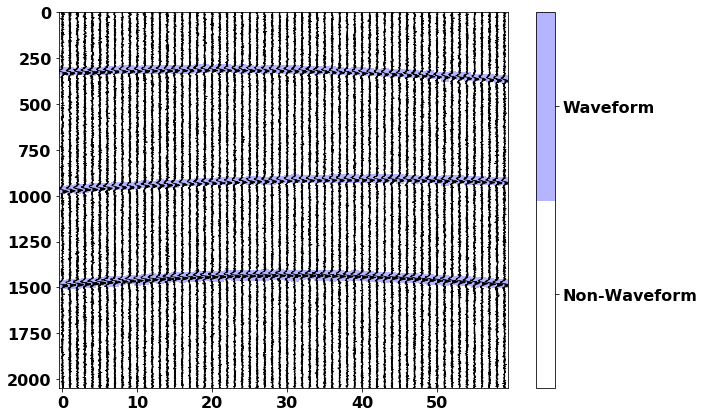

In [8]:
# Plotting and selecting waveform.
from matplotlib.colors import ListedColormap

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

min_max_scaler = preprocessing.MaxAbsScaler()
s1 = min_max_scaler.fit_transform(s1)

indx = np.arange(np.shape(s1)[1])
labels = np.transpose(clabelf)   
count = 0
indx1 = indx[0:np.shape(s1)[1]]
s11 = s1[:][:,count:count+np.shape(s1)[1]]
labelproposed1 = labelproposed[count:count+np.shape(s1)[1]]
labels1 = labels[:,count:count+np.shape(s1)[1]]


cbar_binary = ListedColormap(["white","#B4B4FF"]) 
fig , ax = seisplot_wig1(s11, lw=0.8)
cax=ax.imshow(labels1,aspect='auto',cmap=cbar_binary, vmax=1,vmin=0)
cbar = fig.colorbar(cax)
#cbar.ax.set_xticklabels(['NonWaveform', 'Waveform'])  # vertical colorbar
cbar.set_ticks([0.25,0.75])
cbar.set_ticklabels(['Non-Waveform', 'Waveform'])


# Selecting waveform only.
fin = np.where(labels1==1)
data_denoisev = np.zeros((np.shape(s1)[0],np.shape(s1)[1]))
data_denoisev[fin] = s11[fin]